# 基于LSTM的红楼梦文本生成

In [2]:
from torch import nn
import jieba
import numpy as np
import re
import collections
import torch
from torch.nn import functional as F
import math
import random
import time
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

# 通用module

timer， animator， accumulator

In [3]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
    
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def seq_data_iter_random(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using random sampling.

    Defined in :numref:`sec_language_model`"""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)


def l(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using sequtial partitioning """
    offset = random.randint(0, num_steps)
    num_tokens = (
        (len(corpus) - offset - 1) // batch_size) * batch_size  # 目前的总tokens个数
    Xs = torch.tensor(
        corpus[offset:offset +
               num_tokens])  # offset + num_tokens == len corpus -1 倒数第二个元素
    Ys = torch.tensor(corpus[offset + 1:offset + num_tokens +
                             1])  # offset + num_tokens + 1 是corpus最后一个元素
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)  #
    num_batches = Xs.shape[1] // num_steps  # 每个batch中的东西
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y


class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        """Defined in :numref:`sec_language_model`"""
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_stone(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)
    
def load_corpus_stone(max_tokens=-1):
    """Return token indices and the vocabulary of the stone"""
    lines = read_chinese_file("红楼梦.txt")
    tokens = tokenize(lines)
    vocab = Vocab(tokens, min_freq=0)
    # since each text line in the stone dataset is not necessarily
    # a sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab


def load_data_stone(batch_size,
                    num_steps,
                    use_random_iter=False,
                    max_tokens=10000):
    """Return the iterator and the vocabulary of the stone dataset."""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,
                              max_tokens)
    return data_iter, data_iter.vocab

# nlp module

In [4]:
def read_chinese_file(path):
    """Load the chinese file into a list of text lines."""
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    return [re.sub('\s', ' ', line).strip() for line in lines]


def tokenize(lines):
    """根据jieba分词将lines分成tokens"""
    return [jieba.lcut(line) for line in lines]


def count_corpus(tokens):
    """count the frequency of token"""
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


class Vocab:
    """Vocabulary for text"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(),
                                   key=lambda x: x[1],
                                   reverse=True)
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {
            token: idx
            for idx, token in enumerate(self.idx_to_token)
        }
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.token_to_idx)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            # get 方法，先找第一个字符，找不到再找第二个字符
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

# 模型函数

In [5]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size # 隐藏层参数在rnn层中
        
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
    # inputs 是 batch_size, time, 转成 time, batch_size, 再用one_hot 拉成 time, batch_size, vocab_size
    def forward(self, inputs, states):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, states = self.rnn(X, states)
        # output 最后拉成 time*batch_size * vocab_size的向量，
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, states
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # scratch实现时， 隐藏层为1层， 无第一维，  就是batch_size, num_hiddens维
            return torch.zeros( (self.num_directions * self.rnn.num_layers, batch_size,
                              self.num_hiddens), device=device)
        else: 
            # lstm中有两个隐藏变量， C与H， GRU与RNN都只有一个隐藏单元。 只需要一个隐藏权重
            return (torch.zeros( (self.num_directions * self.rnn.num_layers, batch_size,
                              self.num_hiddens), device=device),
                    torch.zeros( (self.num_directions * self.rnn.num_layers, batch_size,
                              self.num_hiddens), device=device))
        
def grad_clipping(net, theta):
    """Clip the gradient.`"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

            
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu().`"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

# 训练函数

In [6]:
def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, Timer()
    metric = Accumulator(2)
    for X, Y in train_iter:  # X shape [batch_size, time, vocab_size]
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        # label.shape = batch_size, num_steps, 
        y = Y.T.reshape(-1) 
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        
        updater.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        updater.step()
        metric.add(l * torch.numel(y), torch.numel(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch',
                            ylabel='perplexity',
                            legend=['train'],
                            xlim=[10, num_epochs])
    updater = torch.optim.SGD(net.parameters(), lr)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')

# 测试结果

## max_tokens = 10000

In [7]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_stone(batch_size, num_steps, max_tokens=10000)

vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()

num_epochs, lr = 500, 1

lstm_layer = nn.LSTM(len(vocab), num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 2.032 seconds.
Prefix dict has been built successfully.


In [9]:
lines = read_chinese_file("红楼梦.txt")
tokens = tokenize(lines)


In [20]:
print(tokens[1000], '\n len(token): ', len(tokens))

['大家', '想着', '，', '宝玉', '却', '等', '不得了', '，', '也', '不', '等', '贾政', '的', '命', '，', '便', '说道', '：', '“', '旧诗', '有云', '：', '`', '红杏', '梢头', '挂', '酒旗', '-', '．', '如今', '莫若', '`', '杏帘', '在', '望', '-', '四字', '。', '”', '众人', '都', '道', '：', '“', '好', '个', '`', '在', '望', '-', '！', '又', '暗合', '`', '杏花村', '-', '意', '。', '”', '宝玉', '冷笑', '道', '：', '“', '村名', '若用', '`', '杏花', '-', '二字', '，', '则', '俗陋', '不堪', '了', '．', '又', '有', '古人', '诗云', '：', '`', '柴门', '临', '水稻', '花香', '-', '，', '何不', '就', '用', '`', '稻香村', '-', '的', '妙', '？', '"', '众人', '听', '了', '，', '亦', '发哄声', '拍手', '道', '：', '“', '妙', '！', '"', '贾政', '一声', '断喝', '：', '“', '无知', '的', '业障', '，', '你', '能', '知道', '几个', '古人', '，', '能', '记得', '几首', '熟诗', '，', '也', '敢', '在', '老先生', '前', '卖弄', '！', '你', '方才', '那些', '胡说', '的', '，', '不过', '是', '试', '你', '的', '清浊', '，', '取笑', '而已', '，', '你', '就', '认真', '了', '！', '”'] 
 len(token):  5588


In [8]:
vocab_size

44676

perplexity 13.9, 34552.2 tokens/sec on cuda:0


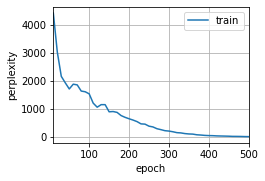

In [17]:
train(model, train_iter, vocab, lr, num_epochs, device) 

perplexity 1.5, 34845.2 tokens/sec on cuda:0


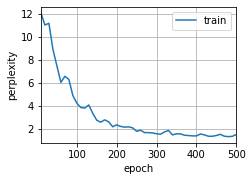

In [18]:
train(model, train_iter, vocab, lr, num_epochs, device) 

perplexity 1.2, 35316.9 tokens/sec on cuda:0


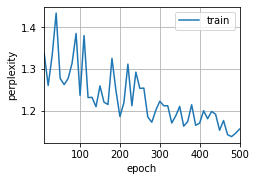

In [19]:
train(model, train_iter, vocab, lr, num_epochs, device) 

In [20]:
num_samples = 400
article = str()
state = (torch.zeros(size=(1,1, num_hiddens), device=device), torch.zeros(size=(1,1, num_hiddens), device=device))
for i in state:
    i = i.to(device)
prob = torch.ones([vocab_size])
_input = torch.multinomial(prob, num_samples=1).unsqueeze(1)

In [21]:
num_samples = 400
article = str()
state = (torch.zeros(size=(1,1, num_hiddens), device=device), torch.zeros(size=(1,1, num_hiddens), device=device))
for i in state:
    i = i.to(device)
prob = torch.ones([vocab_size])
_input = torch.multinomial(prob, num_samples=1).unsqueeze(1)
for i in range(num_samples):
    _input = _input.to(device)
    #print(_input)
    output, state = model(_input, state)
    #print(_input)
    # prob是对上一步得到的output进行指数化，加强高概率结果的权重；
    prob = output.exp()
    # word_id，通过torch_multinomial，以prob为权重，对结果进行加权抽样，样本数为1(即num_samples)
    word_id = torch.multinomial(prob, num_samples=1).item()
    # 为下一次运算作准备，通过fill_方法，把最新的结果(word_id)作为_input的值
    _input.fill_(word_id)
    _input = _input.to(device)
    # print(_input)
    # 从字典映射表Dictionary里，找到当前索引(即word_id)对应的单词；
    word = vocab.idx_to_token[word_id]
    # 如果获得到的单词是特殊符号(如<eos>，句尾符号EndOfSentence)，替换成换行符
    word = '\n' if word == '<eos>' else word
    article += word
print(article)

子长看去公案将弟兄两个．宁公居长倒发了市井儿子当日块去的．《，生了等趣味，不知不知．你敬之问道，未经上。”告诉云，心中，都在在珍爷邀雨村．士隐，放心阊一士隐赠，与谁一片物事草胎两边亲闻了．至也罢此地？”士隐累的如此如此，思忖半晌阅者功德，趣味是此书立意．那绛珠正值仙子雕梁，不是是告诉番书房蓬窗上．说悔脂正浓，巴不得，一语两鬓两鬓成霜？昨日黄土陇头送白骨，今宵之帐底，亲自经历．必是无子而一概，那老僧正值昏此信一块们，其没有和平，聪敏文雅天府退出了一个遂，作别中别家．心中男女着易过小姐，只见又都荒山中来世勋史了．子家人因干过，只有设便不归，那美酒佳肴自不必说．二人归留心，先是款斟漫饮，次渐谈至兴浓，不觉飞觥限?起来．当时街坊虽家家箫管，户户弦歌，当头一轮明月，飞彩凝辉，二人愈添豪兴，酒到杯干．雨村此时已有七八分酒意，狂兴两封，乃对月寓怀，口号一绝云：时逢三五便团圆，满把晴光护玉栏．天上一轮才捧出，人间万姓仰头看．士隐听了，大叫：“妙哉！吾每谓兄必非久居人下者，今所吟之句，飞腾之兆已见，不日可接履于云霓之上矣．可贺，可贺！"乃亲斟一斗为贺．雨村因干过，叹道：“非挣挫酒后狂言，愚之学官员，随落舌钝也袭变成．士隐向一等紧事隔壁旋？，有林深竹轿子处脚和用之地，琏？倒退时之大？"那僧道：“原来，你你！凡书之造劫也。”子兴道忙笑道：“此事 前人商议，何敢狂诞至此。”因问：“老先生何兴至此？"士隐笑道：“今夜中秋，俗谓`团圆之节-，想尊兄


## max_tokens = 20000

perplexity 4.4, 34292.1 tokens/sec on cuda:0


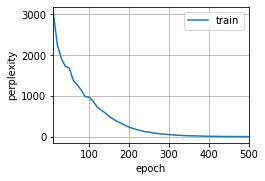

In [23]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_stone(batch_size, num_steps, max_tokens=20000)

vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1

lstm_layer = nn.LSTM(len(vocab), num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
train(model, train_iter, vocab, lr, num_epochs, device) 

perplexity 1.2, 35387.4 tokens/sec on cuda:0


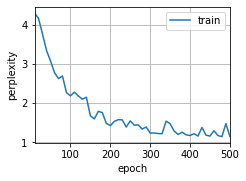

In [24]:
num_epochs, lr = 500, 1
train(model, train_iter, vocab, lr, num_epochs,  device) 

In [1]:
num_samples = 400
article = str()
state = (torch.zeros(size=(1,1, num_hiddens), device=device), torch.zeros(size=(1,1, num_hiddens), device=device))
for i in state:
    i = i.to(device)
prob = torch.ones([vocab_size])
_input = torch.multinomial(prob, num_samples=1).unsqueeze(1)
for i in range(num_samples):
    _input = _input.to(device)
    #print(_input)
    output, state = model(_input, state)
    #print(_input)
    # prob是对上一步得到的output进行指数化，加强高概率结果的权重；
    prob = output.exp()
    # word_id，通过torch_multinomial，以prob为权重，对结果进行加权抽样，样本数为1(即num_samples)
    word_id = torch.multinomial(prob, num_samples=1).item()
    # 为下一次运算作准备，通过fill_方法，把最新的结果(word_id)作为_input的值
    _input.fill_(word_id)
    _input = _input.to(device)
    # print(_input)
    # 从字典映射表Dictionary里，找到当前索引(即word_id)对应的单词；
    word = vocab.idx_to_token[word_id]
    # 如果获得到的单词是特殊符号(如<eos>，句尾符号EndOfSentence)，替换成换行符
    word = '\n' if word == '<eos>' else word
    article += word
print(article)

NameError: name 'torch' is not defined